In [1]:
import os
import torch
import matplotlib.pyplot as plt
import xml.dom.minidom
from skimage.io import imread
from skimage import img_as_ubyte
from pyrr import Matrix44, Vector4, Vector3
import pyrr

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader
)
from pytorch3d.renderer.cameras import look_at_view_transform
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

from torch_openpose.body import Body
from torch_openpose import util
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

from tqdm import tqdm
import torch.nn as nn
import imageio
import cv2
import copy

import wandb

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import pytorch3d

In [15]:
def get_body_image_from_mesh(cur_mesh, body_estimation, renderer):
    R, T = look_at_view_transform(200.0, 10, 0) 
    T[0, 1] = -100
    images = renderer(cur_mesh, R=R.cuda(), T=T.cuda())
        
    rendering_torch_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
    
    heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
    candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)
    rendering_torch_np =  images[0, ..., :3].detach().squeeze().cpu().numpy()
    canvas = copy.deepcopy(rendering_torch_np)
    canvas = util.draw_bodypose(canvas, candidate, subset)
    
    return canvas, candidate, subset, heatmap_avg, paf_avg

def wandb_init(name):
    run = wandb.init(
        project = "pose_opt", 
        reinit = True,
        name = name,
        config={
            "steps": 500,
            "learning_rate": 0.2
        }
    )
    
    return run 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Target')

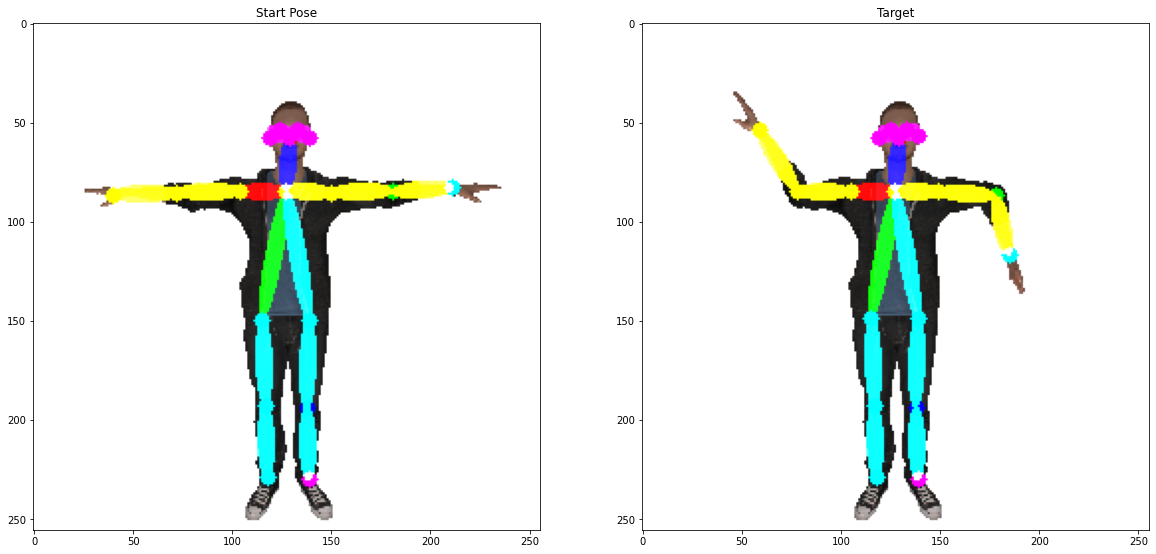

In [16]:
DATA_ROOT = '../data/tshirt_torch/train'

ORIG_SHAPE = (256, 256, 3)

body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
obj_filename = '../openPose/data_set_creator/pose_0_1.obj'
obj_filename_target = '../openPose/data_set_creator/pose_0_3.obj'

# Load obj file
source_mesh = load_objs_as_meshes([obj_filename], device=device)
target_mesh = load_objs_as_meshes([obj_filename_target], device=device)

R, T = look_at_view_transform(200.0, 10, 0) 
T[0, 1] = -100
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

raster_settings = RasterizationSettings(
    image_size=ORIG_SHAPE[0],
    blur_radius=0.0, 
    faces_per_pixel=1,
)
lights = PointLights(device=device, location=[[0.0, 50.0, 50.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ), 
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
    )
)


canvas_orig, *_ = get_body_image_from_mesh(source_mesh, body_estimation, renderer)
canvas_target, *_ = get_body_image_from_mesh(target_mesh, body_estimation, renderer)


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(canvas_orig)

ax.set_title("Start Pose")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(canvas_target)
ax.set_title("Target")

In [17]:
class Model(nn.Module):
    def __init__(self, target_mesh, source_mesh, renderer, body_estimation):
        super().__init__()
        self.device = torch.device("cuda:0")
        self.renderer = renderer
        self.body_estimation = body_estimation
        self.cur_mesh = None
        self.target_mesh = target_mesh
        self.source_mesh = source_mesh
        
        self.deform_verts = nn.Parameter(
             torch.full(source_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
        )
        
        
        ## loss functions
        self.objective = torch.nn.MSELoss()
        self.elev_range = [10, -10, 10, 0]
        self.azim_range = [0, 45, -60,  135]
        R, T = look_at_view_transform(200.0, self.elev_range, self.azim_range) 
        T[:, 1] = -100
        self.R = R.cuda()
        self.T = T.cuda()
        
        meshes = self.target_mesh.extend(len(self.elev_range))
        target_images = self.renderer(meshes, R=self.R, T=self.T)
        target_body_input = (target_images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
        paf, heat = self.body_estimation.model(target_body_input)
        
        self.target_paf = paf
        self.target_heat = heat

    def forward(self):
        w_edge = 0.1 
        # Weight for mesh normal consistency
        w_normal = 0.1 
        # Weight for mesh laplacian smoothing
        w_laplacian = 0.1 
        # Weight for heatmap
        w_pose = 1500
        
        
        self.cur_mesh = self.source_mesh.offset_verts(self.deform_verts)
        
        meshes = self.cur_mesh.extend(len(self.elev_range))
        images = self.renderer(meshes, R=self.R, T=self.T)
        
        body_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
        paf, heat = self.body_estimation.model(body_input)
        
        ob_val_heat = self.objective(heat, self.target_heat)
        ob_val_paf = self.objective(paf, self.target_paf)
        
        # and (b) the edge length of the predicted mesh
        loss_edge = mesh_edge_loss(self.cur_mesh)

        # mesh normal consistency
        loss_normal = mesh_normal_consistency(self.cur_mesh)

        # mesh laplacian smoothing
        loss_laplacian = mesh_laplacian_smoothing(self.cur_mesh, method="uniform")
        
        # Calculate the silhouette loss
        loss = w_pose * (ob_val_heat + ob_val_paf) + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
        return loss, images

In [18]:
# Initialize a model using the renderer, mesh and reference image
model = Model(
    target_mesh=target_mesh,
    source_mesh=source_mesh, 
    renderer=renderer,
    body_estimation=body_estimation
).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
filename_output = "./texture_single_pose_MV.gif"
run = wandb_init('singleMultipleViewReg')
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

In [19]:
for i in tqdm(range(run.config.steps)):
    optimizer.zero_grad()
    loss, cur_image = model()
    loss.backward(retain_graph=True)
    optimizer.step()
    wandb.log({'loss': loss.item()}, step=i)
    
    # Save outputs to create a GIF. 
    
    image = cur_image[0, ..., :3].detach().squeeze().cpu().numpy()
    image = np.clip(image, -1, 1)
    image = img_as_ubyte(image)
    writer.append_data(image)
    
writer.close()

100%|██████████| 500/500 [08:24<00:00,  1.01s/it]


![SegmentLocal](texture_single_pose_MV.gif "segment")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Target')

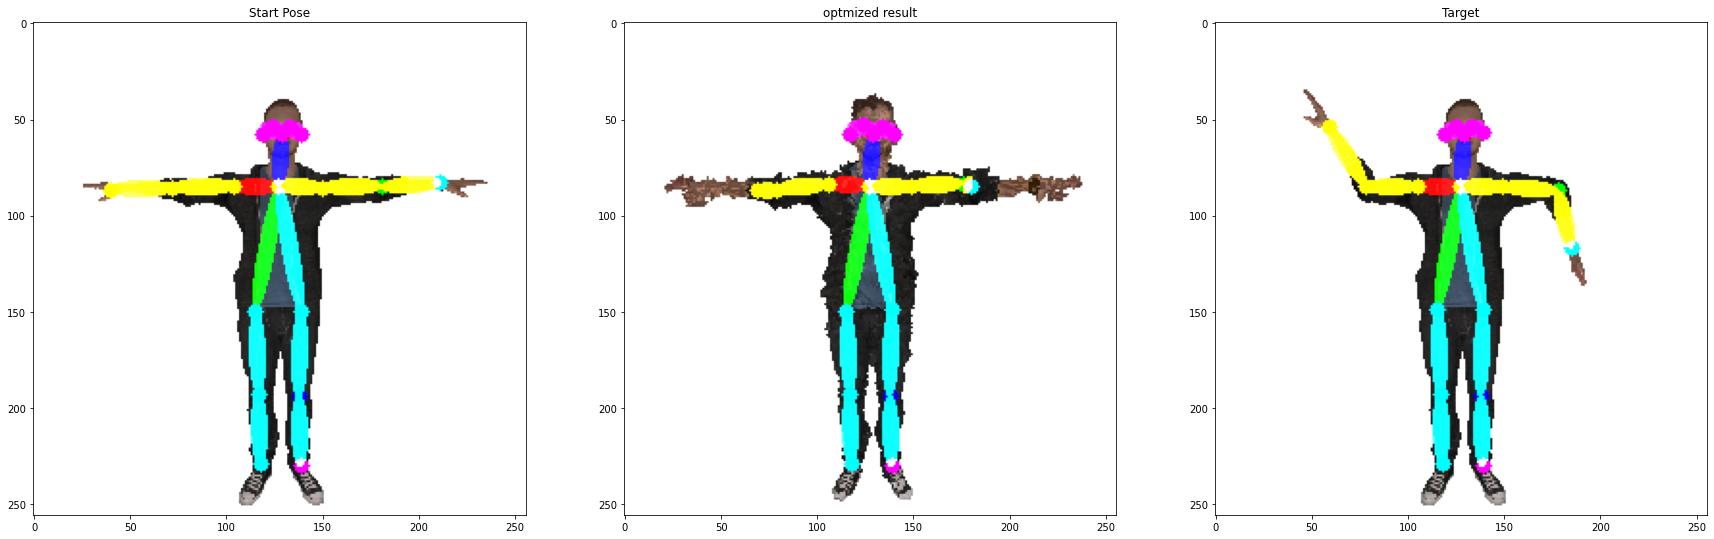

In [20]:
canvas_opt, *_ = get_body_image_from_mesh(model.cur_mesh, body_estimation, renderer)

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(canvas_orig)
ax.set_title("Start Pose")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(canvas_opt)
ax.set_title("optmized result")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(canvas_target)
ax.set_title("Target")